In [1]:
import datetime
import joblib
import torch
import torch.nn

from LSTM_Architecture import LSTM
from pathlib import Path
from Preprocessing_functions import *
from techinical_analysis import * 

In [2]:
ticker = "SPY"
n_clusters = 3 
time_period = "360mo" # must be the same as in 1_Data_Acquisition or larger
#V3 = False # choosing LSTM Architecture - advanced with 2 layers
#BASE = False if V3 == True else True # only 1 layer 

In [3]:

### LOAD KMEANS MODEL ###
KMEANS_PATH = f"kmeans_models/{ticker}/"
#print(os.getcwd())
KMEANS_MODEL_PATH = os.listdir(KMEANS_PATH)
try:
    KMEANS_MODEL_PATH.remove('Junk')
except ValueError:
    print(' ')    

print(KMEANS_MODEL_PATH)
idx = 0 if len(KMEANS_MODEL_PATH) < 2 else int(input("Select file index: "))
KMEANS_NAME = KMEANS_MODEL_PATH[idx]
print("Chosen K_MEANS MODEL file: ", KMEANS_NAME)
FILE = KMEANS_PATH + KMEANS_NAME
loaded_kmeans = joblib.load(FILE)

### LOAD FEAT LIST TO ORDER THE DATA ###
FEAT_PATH = f"model_features/{ticker}/"
FEAT_FILES = os.listdir(FEAT_PATH)
try:
    FEAT_FILES.remove('Junk')
except ValueError:
    print(' ')
print(FEAT_FILES)
idx = 0 if len(FEAT_FILES) < 2 else int(input("Select file index (e.g. 0,1,2)"))
FEAT_NAME = FEAT_FILES[idx]
MODEL_FEAT = pd.read_csv(FEAT_PATH + FEAT_NAME)['0'].to_list()
#MODEL_FEAT.pop(-1)

# Cluster stats
STATS_PATH = f"Data/{ticker}/k_stats/"
STATS_FILES = os.listdir(STATS_PATH)
try:
    STATS_FILES.remove('Junk')
except ValueError:
    print(' ')
print("KMEANS Stats files: ", STATS_FILES)
idx = 0 if len(STATS_FILES) < 2 else int(input("Select file index: "))
STATS_NAME = STATS_FILES[idx]
print("Chosen K_STATS file: ", STATS_NAME)
cluster_stats = pd.read_csv(STATS_PATH + STATS_NAME).set_index("Unnamed: 0")

# LOAD DF FOR MODEL BUILDING TO CHECK DATE RANGES 
DF_PATH = f"Data/{ticker}/df/"
DF_FILES = os.listdir(DF_PATH)
try:
    DF_FILES.remove('Junk')
except ValueError:
    print(' ')
print("DataFrames for model building: ", DF_FILES)
idx = 0 if len(DF_FILES) < 2 else int(input("Select file index: "))
DF_NAME = DF_FILES[idx] 
print("Chosen DataFrame file: ", DF_NAME)
df_dates = pd.read_parquet(DF_PATH + DF_NAME)
df_dates = format_idx_date(df_dates)

# LOAD LSTM MODEL STATE DICT  
MODEL_PATH = f"lstm_models/{ticker}/"
LSTM_FILES = os.listdir(MODEL_PATH)
try:
    LSTM_FILES.remove('Junk')
except ValueError:
    print(' ')
print("LSTM Files: ",LSTM_FILES)
idx = 0 if len(LSTM_FILES) < 2 else int(input("Select file index: "))
MODEL_NAME = LSTM_FILES[idx]
print("Chosen LSTM, MODEL file: ", MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['kmeans_model_df_SPY_k3_202402012133.joblib']
Chosen K_MEANS MODEL file:  kmeans_model_df_SPY_k3_202402012133.joblib
['LSTM_df_SPY_k3_202402012133_NFEAT23.csv']
KMEANS Stats files:  ['KMEANS_Stats_df_SPY_k3_202402012133.csv']
Chosen K_STATS file:  KMEANS_Stats_df_SPY_k3_202402012133.csv
DataFrames for model building:  ['df_SPY_k3_202402012133.parquet']
Chosen DataFrame file:  df_SPY_k3_202402012133.parquet
LSTM Files:  ['LSTM_Class_df_SPY_k3_202402012133_Epoch_215_TestAcc_80.80_TrainAcc_72.78_202402012138']
Chosen LSTM, MODEL file:  LSTM_Class_df_SPY_k3_202402012133_Epoch_215_TestAcc_80.80_TrainAcc_72.78_202402012138


c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
### DOWNLOAD DATA ###
df = downlaod_symbol_data(ticker, period = time_period)
# Use an alternative to yfinance
#df = download_data(ticker, days = 7200)
df = format_idx_date(df)
print('Start date: ',df.index.min())
df.head()

Start date:  1995-04-18 00:00:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,open_high,high_low,low_close,high_close,gap
Date,,,,,,,,,,,,,,,
1995-04-18,29.93,29.93,29.73,29.80,329500,0.0,0.0,0.0,0.668226,0.434347,0.000000,0.668226,-0.235452,-0.434347,NaN
1995-04-19,29.80,29.87,29.62,29.78,223000,0.0,0.0,0.0,0.604027,0.067114,-0.234899,0.836960,-0.540176,-0.301306,0.000000
1995-04-20,29.86,29.91,29.70,29.82,207900,0.0,0.0,0.0,0.535834,0.133958,-0.167448,0.702106,-0.404040,-0.300903,0.268637
1995-04-21,29.83,29.98,29.83,29.97,145000,0.0,0.0,0.0,0.000000,-0.469326,-0.502849,0.500334,-0.469326,-0.033356,0.033535
1995-04-24,29.95,30.32,29.95,30.32,169000,0.0,0.0,0.0,0.000000,-1.235392,-1.235392,1.220317,-1.235392,0.000000,-0.066733


In [5]:
# REMOVE DATA SNOOPING 
out_sample = True
manual = False

if out_sample is True:
    
    if manual != True:
        start_date = df_dates.index.min()
        df = df[df.index <= start_date]
    
    else: 
        #Manually choosing the cutoff date
        df = df[df.index >= '2022-07-01']
        #df = df[df.index >= '2010-01-01']
    
    del DF_NAME, df_dates 

In [6]:
df = create_momentum_feat(df, ticker).dropna()
df = momentum_oscillators(df)
df = volatility(df)
df = reversal_patterns(df) 
df = continuation_patterns(df)
df = magic_doji(df)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Capital Gains', 'open_low', 'open_close', 'open_high', 'high_low',
       'low_close', 'high_close', 'gap', 'SPY_mom1', 'SPY_mom2', 'SPY_mom3',
       'SPY_mom4', 'SPY_mom5', 'SPY_mom10', 'SPY_mom15', 'SPY_mom20',
       'SPY_mom60', 'SPY_mom120', 'SPY_mom180', 'SPY_mom240', 'rsi',
       'macd_values', 'macd_signal_line', 'atr', 'bband_up', 'bband_mid',
       'bband_low', 'hammer', 'hanging_man', 'engulfing_pattern', 'dark_cloud',
       'piercing_line', 'morning_star', 'evening_star', 'shooting_star',
       'inverted_hammer', 'harami', 'harami_cross', 'belt_hold',
       'upsidegap_two_crows', 'three_black_crows', 'three_white_soldiers',
       'advance_block', 'stalled_pattern', 'counterattack', 'tasuki',
       'rf_three_methods', 'separating_lines', 'long_legged_doji',
       'gravestone_doji', 'dragonfly_doji', 'tristar_doji'],
      dtype='object')

In [7]:
### ASSIGN CLUSTER TO OBSERVATION ###
data = df[["open_low", "open_close", "gap"]].dropna()
print(data.shape)
k_predictions = pd.DataFrame(loaded_kmeans.predict(data), columns = ["labels"], index = data.index)
#data = data.merge(k_predictions, left_index = True, right_index = True)#.reset_index()
del FILE, KMEANS_PATH, loaded_kmeans

df_model = df.merge(k_predictions, left_index = True, right_index = True)
df_model.head()

(4733, 3)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,stalled_pattern,counterattack,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-28,38.83,39.14,38.82,39.12,1001300,0.0,0.0,0.0,0.025753,-0.746845,...,0,0,0,0,0,0,0,0,0,1
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,0,0
1996-04-01,39.12,39.39,39.00,39.39,773400,0.0,0.0,0.0,0.306748,-0.690184,...,0,0,0,0,0,0,0,0,0,1
1996-04-02,39.43,39.46,39.30,39.46,638800,0.0,0.0,0.0,0.329698,-0.076084,...,0,0,0,0,0,0,0,0,0,2
1996-04-03,39.32,39.49,39.23,39.46,288000,0.0,0.0,0.0,0.228891,-0.356053,...,0,0,0,0,0,0,0,0,0,2


In [8]:
# LSTM HYPERPARAMETERS
seq_length =  1
input_feat = len(MODEL_FEAT)
hidden_size = 32
num_layers = 2 
num_classes = 3

# INSTANTIATE MODEL
model = LSTM(input_size=input_feat, 
            output_size=num_classes, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            device=device).to(device)

# LOAD LSTM MODEL STATE DICT  
model.load_state_dict(torch.load(f = MODEL_PATH + MODEL_NAME ))

<All keys matched successfully>

In [9]:
##### RENAME MODEL FEATURES WHERE TICKERS DO NOT COINCIDE FOR TESTING SPY MODEL ON OTHERS 
MODEL_FEAT = [i.replace('SPY', ticker) for i in MODEL_FEAT]

df_model['last_day'] = 1 

len(MODEL_FEAT)

23

### PREDICTIONS LOOP 

In [10]:
dates = df_model.index

days_passed = 0 

model_predictions = {}

for day in dates: 
    
    if days_passed >= 2:
        
        ### SELECT DATA FROM MASTER DF - df_model 
        row = df_model[df_model.index <= day]
        print(row.index.max())
        #print(row.index.min())
        row = row.tail(2)
        # I want to predict the latest day (hence ascending = False)
        row = row.sort_index(ascending=False)

        ### CONVERT ROW TO TENSORS
        df_lstm = row[MODEL_FEAT]
        df_lstm = min_max_scaling(df_lstm)
        df_lstm.columns = MODEL_FEAT
        
        X, y = create_multivariate_rnn_data(df_lstm, seq_length)
        X_tensor = torch.from_numpy(X).type(torch.float).to(device)#.squeeze(0)
        del X, y
        
        ### PREDICTION FOR THE DAY 
        model.eval()
        with torch.inference_mode():

            output = model(X_tensor)
            pred = torch.softmax(output, dim = 1).argmax(dim = 1)
        
        prediction = pred.item()
        
        model_predictions[day] = prediction
        ## possible mistake in creating the predictions df - dates might not align properly
        #predictions = pd.DataFrame(pred.to("cpu").numpy(), columns = ["predictions"], index = df_model.index[:-1])

        #break
    
    days_passed += 1 
    

1996-04-01 00:00:00
1996-04-02 00:00:00
1996-04-03 00:00:00
1996-04-04 00:00:00
1996-04-08 00:00:00
1996-04-09 00:00:00
1996-04-10 00:00:00
1996-04-11 00:00:00
1996-04-12 00:00:00
1996-04-15 00:00:00
1996-04-16 00:00:00
1996-04-17 00:00:00
1996-04-18 00:00:00
1996-04-19 00:00:00
1996-04-22 00:00:00
1996-04-23 00:00:00
1996-04-24 00:00:00
1996-04-25 00:00:00
1996-04-26 00:00:00
1996-04-29 00:00:00
1996-04-30 00:00:00
1996-05-01 00:00:00
1996-05-02 00:00:00
1996-05-03 00:00:00
1996-05-06 00:00:00
1996-05-07 00:00:00
1996-05-08 00:00:00
1996-05-09 00:00:00
1996-05-10 00:00:00
1996-05-13 00:00:00
1996-05-14 00:00:00
1996-05-15 00:00:00
1996-05-16 00:00:00
1996-05-17 00:00:00
1996-05-20 00:00:00
1996-05-21 00:00:00
1996-05-22 00:00:00
1996-05-23 00:00:00
1996-05-24 00:00:00
1996-05-28 00:00:00
1996-05-29 00:00:00
1996-05-30 00:00:00
1996-05-31 00:00:00
1996-06-03 00:00:00
1996-06-04 00:00:00
1996-06-05 00:00:00
1996-06-06 00:00:00
1996-06-07 00:00:00
1996-06-10 00:00:00
1996-06-11 00:00:00


#### KEYNOTE: 

- Day (date) needs to be incremented by 1 day to reflect the prediction for this day (which is carried out with the data for the previous day) 
- Solution: shift data by 1 after the loop

In [11]:
predictions = pd.DataFrame(model_predictions, index = ['predictions']).transpose()
predictions = predictions.shift(1)
predictions

,predictions
1996-04-01,NaN
1996-04-02,1.0
1996-04-03,1.0
1996-04-04,1.0
1996-04-08,2.0
...,...
2015-01-09,1.0
2015-01-12,1.0
2015-01-13,2.0
2015-01-14,1.0


In [12]:
df_model = df_model.merge(predictions, left_index=True, right_index=True, how = 'left')
df_model.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels,last_day,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-28,38.83,39.14,38.82,39.12,1001300,0.0,0.0,0.0,0.025753,-0.746845,...,0,0,0,0,0,0,0,1,1,NaN
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,1,NaN
1996-04-01,39.12,39.39,39.00,39.39,773400,0.0,0.0,0.0,0.306748,-0.690184,...,0,0,0,0,0,0,0,1,1,NaN
1996-04-02,39.43,39.46,39.30,39.46,638800,0.0,0.0,0.0,0.329698,-0.076084,...,0,0,0,0,0,0,0,2,1,1.0
1996-04-03,39.32,39.49,39.23,39.46,288000,0.0,0.0,0.0,0.228891,-0.356053,...,0,0,0,0,0,0,0,2,1,1.0


In [ ]:
### CALCULATE MODEL ACCURACY 
df_acc = df_model[['labels', 'predictions']].dropna()
#df_acc.predictions = df_acc.predictions.replace(0,2)
#df_acc.labels = df_acc.labels.replace(0,2)
df_acc['true_false_prediction'] = (df_acc['labels'] == df_acc['predictions'])
print('Accuracy: %', round(df_acc['true_false_prediction'].sum() / df_acc.shape[0], 4)*100)

Accuracy: % 43.09


#### BACKTESTING LOOP 

In [14]:
df2 = df_model.copy()
df2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels,last_day,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-28,38.83,39.14,38.82,39.12,1001300,0.0,0.0,0.0,0.025753,-0.746845,...,0,0,0,0,0,0,0,1,1,NaN
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,1,NaN
1996-04-01,39.12,39.39,39.00,39.39,773400,0.0,0.0,0.0,0.306748,-0.690184,...,0,0,0,0,0,0,0,1,1,NaN
1996-04-02,39.43,39.46,39.30,39.46,638800,0.0,0.0,0.0,0.329698,-0.076084,...,0,0,0,0,0,0,0,2,1,1.0
1996-04-03,39.32,39.49,39.23,39.46,288000,0.0,0.0,0.0,0.228891,-0.356053,...,0,0,0,0,0,0,0,2,1,1.0


In [15]:
# =============================================================================
# #### BACKTESTING ####
# =============================================================================
#tc = 3

#create a list of clusters to use in the backtesting df1
k_names = []

for n in range(0,3):
    
    open_low = cluster_stats[f'open_low_{n}']['median']
    open_close = cluster_stats[f'open_close_{n}']['median']
    
    if open_low and open_close >= 0:
        k_names.append(n)
        
    if open_low > open_close and open_low > 0 and abs(open_close)*3 < open_low:
        if n not in k_names:
            k_names.append(n)

In [16]:
### CHOOSE A START DATE FROM THE RETURNS FILES 
from dateutil.relativedelta import relativedelta
start_date_returns = '2006-01-01' # choose here
df2 = df2[df2.index >= start_date_returns]
df_start_date = df2.index.min()

# historic returns for this strategy 
#print('End date: ', end_date)
print('Start date: ', df_start_date)

Start date:  2006-01-03 00:00:00


In [17]:
###### HALF KELLY AND RETURNS CHOICE (mixed_returns or no_kelly_criterion_returns)#######
half_kelly_metric = True
returns_path = 'strat_returns/Testing/no_kelly_criterion_returns'
mixed_returns = False
#############################

In [18]:
### INIATIALIZE PARAMETERS - kelly, capital, trade clusters etc ###

start_capital = 1e4
no_trade_k = [i for i in range(0,3) if i not in k_names][0]
df = pd.DataFrame()
tc = 0.003

if half_kelly_metric is True:
    
    hk_date = (df_start_date + relativedelta(months= 6)).strftime('%Y-%m-%d')
    print('HK Start date: ', hk_date)
    df2 = df2[df2.index >= hk_date]
    
    try:
        half_kelly = kelly_criterion(ticker, date_to=hk_date, path = 'strat_returns/Testing/no_kelly_criterion_returns') / 2 
    except FileNotFoundError:
        half_kelly = 1
        print('NO Half Kelly Available')
else: 
    half_kelly = 1 

HK Start date:  2006-07-03
Kelly Calculation window: From: 2006-01-03 00:00:00 To: 2006-07-03 00:00:00


In [19]:
 
for date, row in df2.iterrows():
    #break
    if half_kelly_metric is True:
        try:
            half_kelly = kelly_criterion(ticker, date, path = returns_path) / 2
        except FileNotFoundError:
            half_kelly =  1
            print(date)
    
    else: 
        half_kelly = 1 
        print('No kelly critetion: ', date)
        
        
    for k in range(len(k_names)):
        
        #row['bp_used'] = (start_capital * half_kelly, 2) # needs more work to fix dataypes error (passing sequence)
        row['shares'] = (start_capital * half_kelly) // row['Close'] ## you need to divide cluster stats from target with USO - check clusters stats df for % or decimals 
        row[f'target_{k_names[k]}'] = round((1 - cluster_stats.loc["median" , f"open_low_{k_names[k]}"]/100) * row['Open'], 2) 
        row[f'k{k_names[k]}_true'] = (row[f'target_{k_names[k]}'] >= row['Low']) 
        row[f'k{k_names[k]}_profit'] = (row[f'k{k_names[k]}_true'] * (row['Open'] - row[f'target_{k_names[k]}']))* row['shares']
        row[f'k{k_names[k]}_loss'] = round(((row['Open'] - row['Close']) * row['shares']),4)
        row[f'k{k_names[k]}_pnl'] = np.where(row[f'k{k_names[k]}_true'] == True, row[f'k{k_names[k]}_profit'], row[f'k{k_names[k]}_loss'])
        del row[f'k{k_names[k]}_profit'], row[f'k{k_names[k]}_loss']
        
    
    row[f'k{k_names[0]}_k{k_names[1]}'] = np.where(row['predictions'] == 0, row[f'k{k_names[0]}_pnl'], row[f'k{k_names[1]}_pnl'])
    row['k0_k1_k2'] = np.where(row['predictions'] == no_trade_k, 0, row[f'k{k_names[0]}_k{k_names[1]}'] )
    row['tc'] = 2*(row['shares'] * tc) # new line for tc 
    row['net_pnl'] = np.where(row['k0_k1_k2'] != 0, row['k0_k1_k2'] - row['tc'], 0)
    row['eod_equity'] = start_capital + row['net_pnl']
    row['daily_ret'] = row['eod_equity'] / start_capital - 1
    row['half_kelly'] = half_kelly
    
    start_capital += row['net_pnl']
    df = pd.concat([df, row.to_frame().transpose()], axis= 0)
    
    ########### UPDATE RETURNS ####################
    if mixed_returns is True: 
        df_returns = pd.read_csv(returns_path +'/' + ticker + '.csv', index_col='date')
        df_returns = df_returns[df_returns.index < date.strftime('%Y-%m-%d')]
        new_row = row[list(df_returns.columns)].to_frame().transpose()
        df_returns = pd.concat([df_returns, new_row], axis = 0)
        df_returns = df_returns.infer_objects()
        df_returns.index = pd.to_datetime(df_returns.index)
        df_returns.index.name = 'date'
        df_returns.to_csv(returns_path +'/' + ticker + '.csv')
        

Kelly Calculation window: From: 2006-01-03 00:00:00 To: 2006-07-03 00:00:00
Kelly Calculation window: From: 2006-01-05 00:00:00 To: 2006-07-05 00:00:00
Kelly Calculation window: From: 2006-01-06 00:00:00 To: 2006-07-06 00:00:00
Kelly Calculation window: From: 2006-01-09 00:00:00 To: 2006-07-07 00:00:00
Kelly Calculation window: From: 2006-01-10 00:00:00 To: 2006-07-10 00:00:00
Kelly Calculation window: From: 2006-01-11 00:00:00 To: 2006-07-11 00:00:00
Kelly Calculation window: From: 2006-01-12 00:00:00 To: 2006-07-12 00:00:00
Kelly Calculation window: From: 2006-01-13 00:00:00 To: 2006-07-13 00:00:00
Kelly Calculation window: From: 2006-01-17 00:00:00 To: 2006-07-14 00:00:00
Kelly Calculation window: From: 2006-01-17 00:00:00 To: 2006-07-17 00:00:00
Kelly Calculation window: From: 2006-01-18 00:00:00 To: 2006-07-18 00:00:00
Kelly Calculation window: From: 2006-01-19 00:00:00 To: 2006-07-19 00:00:00
Kelly Calculation window: From: 2006-01-20 00:00:00 To: 2006-07-20 00:00:00
Kelly Calcul

In [20]:
### FORMAT df - datatypes 
for col in list(df.columns):
    
    if ("true" or "last_day") in col:
        df[col] = df[col].astype("bool")
        
    elif ("labels" or "Volume" or "predictions") in col:
        df[col] = df[col].astype("int32")
    
    else:
        df[col] = df[col].astype("float64")
    
#del df2

df1 = df.copy()

df1['pnl_cumsum'] = df1['net_pnl'].cumsum()

In [21]:
#####################################################################
 # PERFORMANCE EVALUATION 
#####################################################################

#####   MAX DRAWDOWN
from calculateMaxDD import calculateMaxDD

cum_ret = np.cumprod(1+ df1['daily_ret']) - 1
maxDrawdown, maxDrawdownDuration, startDrawdownDay=calculateMaxDD(cum_ret.values)

#####   SHARPE RATIO
sharpe_ratio = round(np.sqrt(252) * np.mean(df1['daily_ret']) / np.std(df1['daily_ret']),2)

#####   AVG YEARLY RETURN AND STD
mean_ret = df1['daily_ret'].mean() * 252
std = df1['daily_ret'].std()*np.sqrt(252)

p_change = df1['Close'].pct_change().dropna() #/ df1['Close'].shift(1)
corr = np.corrcoef(p_change, df1['Close'][1:])

print(f"Correlation Price / Return: " , round(corr[1][0], 2))
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Maximum Drawdown: {round(maxDrawdown,4)}')
print(f'Max Drawdown Duration: {maxDrawdownDuration} days' )
print(f'Start day Drawdown: {startDrawdownDay}')
print(f"Average Yearly Return: {round(mean_ret*100, 2)} %")

Correlation Price / Return:  0.03
Sharpe Ratio: 0.32
Maximum Drawdown: -0.5632
Max Drawdown Duration: 822.0 days
Start day Drawdown: 1938
Average Yearly Return: 8.0 %


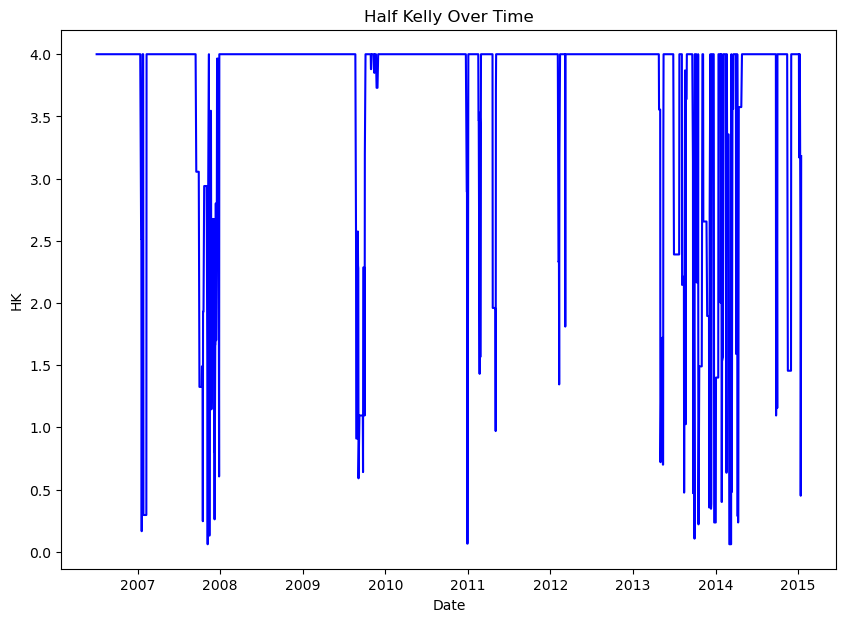

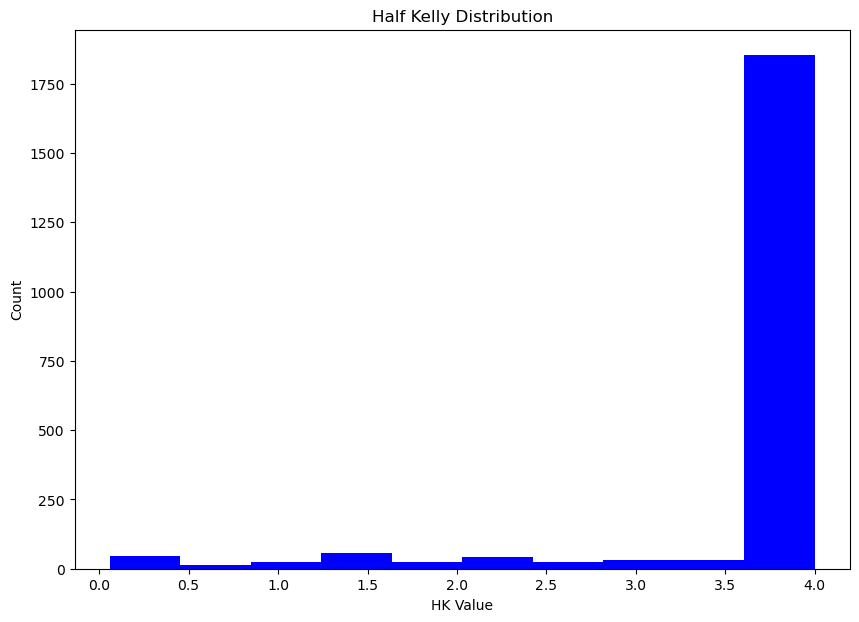

In [22]:

if half_kelly_metric is True:

    ### HALF KELLY PROGRESSION OVER TIME 
    plt.figure(figsize=[10,7])
    plt.plot(df1.index, df1.half_kelly, color = 'b')
    plt.title('Half Kelly Over Time')
    plt.xlabel('Date')
    plt.ylabel('HK')

    plt.figure(figsize=[10,7])
    plt.hist(df1['half_kelly'], color = 'b')
    plt.title('Half Kelly Distribution')
    plt.xlabel('HK Value')
    plt.ylabel('Count')


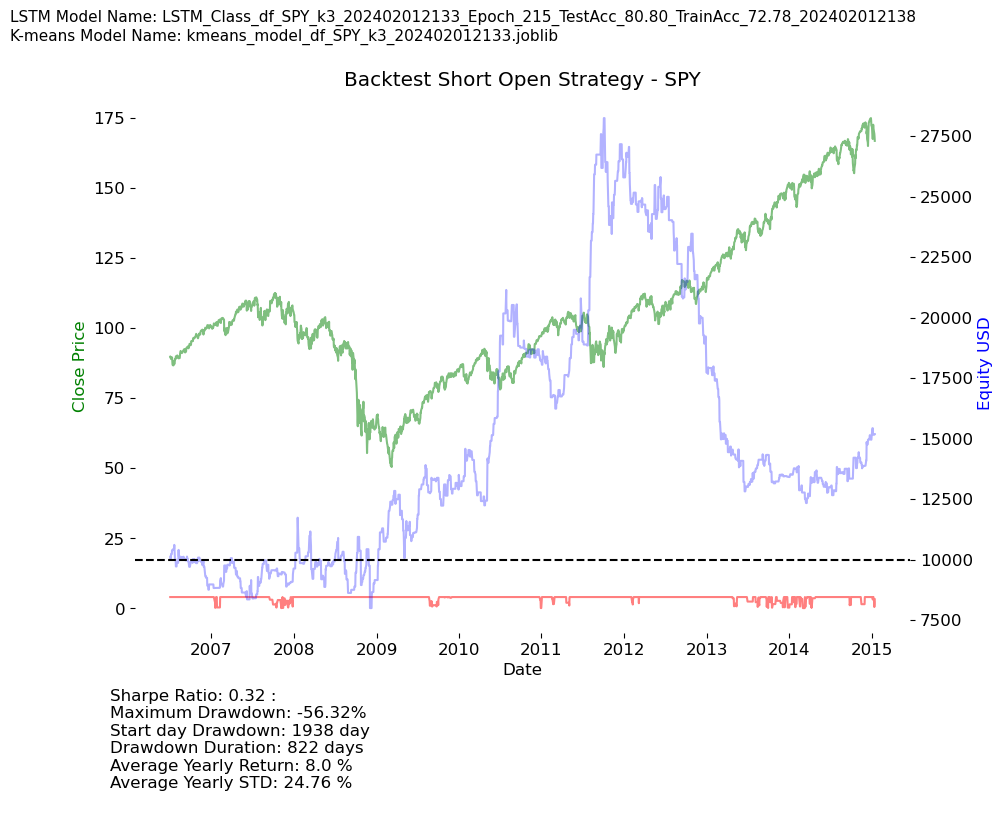

In [23]:

# Create figure and axis objects
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(figsize=(10, 7))
plt.title(f"Backtest Short Open Strategy - {ticker}")

# Plot data on the first y-axis
ax1.plot(df1.index, df1['Close'], 'g-', alpha = 0.5)
ax1.plot(df1.index, df1['half_kelly'], 'red', alpha = 0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price ', color='g')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df1.index, df1['eod_equity'], 'b-', alpha = 0.3)
ax2.set_ylabel('Equity USD', color='b')

# Add black dotted line at y=0
#ax1.axhline(y=0, color='k', linestyle='--')
ax2.axhline(y=1e4, color='k', linestyle='--')

#Remove box lines around the chart area
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add text box
stats_text = f'Sharpe Ratio: {sharpe_ratio} :\n'
stats_text += f'Maximum Drawdown: {round(maxDrawdown*100,2)}% \n'
stats_text += f'Start day Drawdown: {startDrawdownDay} day \n'
stats_text += f"Drawdown Duration: {int(maxDrawdownDuration)} days \n"
stats_text += f"Average Yearly Return: {round(mean_ret*100, 2)} % \n"
stats_text += f"Average Yearly STD: {round(std*100, 2)} % \n"
fig.text(0.1, 0.03, stats_text, fontsize=12,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.5,edgecolor='none'))

model_info = f'LSTM Model Name: '
model_info += f'{MODEL_NAME} \n'
model_info += f'K-means Model Name: '
model_info += f'{KMEANS_NAME}'
fig.text(
    0, 1, model_info, fontsize=11,
    verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5,edgecolor='none'))



### SAVING THE PLOT 
save = True 
if save is True:
    #plt.savefig(f"Short_Open_Backtests/kelly_backtests/Backtest_{ticker}.jpeg", bbox_inches='tight')

    if out_sample is True: 
        if mixed_returns is True:
            plt.savefig(f"Short_Open_Backtests/out_sample/mixed_returns/Backtest_{ticker}.jpeg", bbox_inches='tight')
        if df1.half_kelly.max() == df1.half_kelly.min(): # no kelly returns 
            plt.savefig(f"Short_Open_Backtests/out_sample/no_half_kelly/Backtest_{ticker}.jpeg", bbox_inches='tight')
        if df1.half_kelly.max() > 1 : 
            if mixed_returns is False: 
                plt.savefig(f"Short_Open_Backtests/out_sample/half_kelly/Backtest_{ticker}.jpeg", bbox_inches='tight')

    if out_sample is False: 
        if mixed_returns is True:
            plt.savefig(f"Short_Open_Backtests/insample/mixed_returns/Backtest_{ticker}.jpeg", bbox_inches='tight')
        if df1.half_kelly.max() == df1.half_kelly.min(): # no kelly returns 
            plt.savefig(f"Short_Open_Backtests/insample/no_half_kelly/Backtest_{ticker}.jpeg", bbox_inches='tight')
        if df1.half_kelly.max() > 1 : 
            if mixed_returns is False: 
                plt.savefig(f"Short_Open_Backtests/insample/half_kelly/Backtest_{ticker}.jpeg", bbox_inches='tight')


plt.show()


In [24]:
df1.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,k2_true,k2_pnl,k0_k2,k0_k1_k2,tc,net_pnl,eod_equity,daily_ret,half_kelly,pnl_cumsum
2015-01-02,172.87,173.29,171.03,172.08,121465900.0,0.0,0.0,0.0,1.064384,0.456991,...,True,235.96,235.96,235.96,2.082,233.878,15187.248,0.015640,4.00,5187.248
2015-01-05,171.02,171.19,168.66,168.97,169632600.0,0.0,0.0,0.0,1.379956,1.198690,...,True,244.12,244.12,244.12,2.154,241.966,15429.214,0.015932,4.00,5429.214
2015-01-06,169.28,169.81,166.57,167.38,209151400.0,0.0,0.0,0.0,1.600898,1.122401,...,True,195.64,195.64,0.00,1.752,0.000,15429.214,0.000000,3.17,5429.214
2015-01-07,168.72,169.81,168.26,169.46,125346700.0,0.0,0.0,0.0,0.272641,-0.438596,...,False,-269.36,-269.36,-269.36,2.184,-271.544,15157.670,-0.017599,4.00,5157.670
2015-01-08,170.89,172.69,170.87,172.47,147217800.0,0.0,0.0,0.0,0.011703,-0.924571,...,False,-554.58,-554.58,0.00,2.106,0.000,15157.670,0.000000,4.00,5157.670
2015-01-09,172.89,172.90,170.47,171.09,158567300.0,0.0,0.0,0.0,1.399734,1.041124,...,True,240.72,240.72,0.00,2.124,0.000,15157.670,0.000000,4.00,5157.670
2015-01-12,171.22,171.38,169.14,169.75,144396100.0,0.0,0.0,0.0,1.214811,0.858545,...,True,143.48,143.48,0.00,1.266,0.000,15157.670,0.000000,2.37,5157.670
2015-01-13,170.98,172.12,167.95,169.27,214553300.0,0.0,0.0,0.0,1.772137,1.000117,...,True,27.20,27.20,27.20,0.240,26.960,15184.630,0.001779,0.45,5184.630
2015-01-14,167.23,168.45,166.33,168.25,192991100.0,0.0,0.0,0.0,0.538181,-0.609938,...,True,81.18,81.18,0.00,0.738,0.000,15184.630,0.000000,1.37,5184.630
2015-01-15,168.89,169.21,166.59,166.71,176613900.0,0.0,0.0,0.0,1.361833,1.290781,...,True,193.63,193.63,0.00,1.734,0.000,15184.630,0.000000,3.18,5184.630


In [25]:
df_acc

,labels,predictions,true_false_prediction
Date,,,
1996-04-02,2,1.0,False
1996-04-03,2,1.0,False
1996-04-04,2,1.0,False
1996-04-08,2,2.0,True
1996-04-09,2,2.0,True
...,...,...,...
2015-01-09,2,1.0,False
2015-01-12,2,1.0,False
2015-01-13,2,2.0,True


In [26]:
df_acc.predictions = df_acc.predictions.replace(0,2)
df_acc

,labels,predictions,true_false_prediction
Date,,,
1996-04-02,2,1.0,False
1996-04-03,2,1.0,False
1996-04-04,2,1.0,False
1996-04-08,2,2.0,True
1996-04-09,2,2.0,True
...,...,...,...
2015-01-09,2,1.0,False
2015-01-12,2,1.0,False
2015-01-13,2,2.0,True


### RESEARCH NOTE: Testing create_multivariate_rnn_data ###

In [27]:
df_model.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels,last_day,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-28,38.83,39.14,38.82,39.12,1001300,0.0,0.0,0.0,0.025753,-0.746845,...,0,0,0,0,0,0,0,1,1,NaN
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,1,NaN
1996-04-01,39.12,39.39,39.00,39.39,773400,0.0,0.0,0.0,0.306748,-0.690184,...,0,0,0,0,0,0,0,1,1,NaN
1996-04-02,39.43,39.46,39.30,39.46,638800,0.0,0.0,0.0,0.329698,-0.076084,...,0,0,0,0,0,0,0,2,1,1.0
1996-04-03,39.32,39.49,39.23,39.46,288000,0.0,0.0,0.0,0.228891,-0.356053,...,0,0,0,0,0,0,0,2,1,1.0


In [28]:
df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,k2_true,k2_pnl,k0_k2,k0_k1_k2,tc,net_pnl,eod_equity,daily_ret,half_kelly,pnl_cumsum
2006-07-03,89.48,89.89,89.40,89.74,23914000.0,0.0,0.0,0.0,0.089405,-0.290568,...,False,-115.70,-115.70,0.00,2.670,0.000,10000.000,0.000000,4.0,0.000
2006-07-05,89.38,89.49,88.84,89.23,69653400.0,0.0,0.0,0.0,0.604162,0.167823,...,True,156.80,156.80,156.80,2.688,154.112,10154.112,0.015411,4.0,154.112
2006-07-06,89.32,89.77,89.23,89.49,50100300.0,0.0,0.0,0.0,0.100761,-0.190327,...,False,-77.01,-77.01,-77.01,2.718,-79.728,10074.384,-0.007852,4.0,74.384
2006-07-07,89.31,89.57,88.68,88.90,81626500.0,0.0,0.0,0.0,0.705408,0.459075,...,True,158.55,158.55,158.55,2.718,155.832,10230.216,0.015468,4.0,230.216
2006-07-10,89.14,89.48,88.76,89.07,60964100.0,0.0,0.0,0.0,0.426296,0.078528,...,True,160.65,160.65,0.00,2.754,0.000,10230.216,0.000000,4.0,230.216


In [29]:
test = df_model.head(2)


x, y = create_multivariate_rnn_data(test, seq_length)

x.shape

(1, 1, 62)

In [30]:
y.shape

(1, 62)

In [31]:
y

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels,last_day,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,1,NaN


In [32]:
x

array([[[ 3.88300000e+01,  3.91400000e+01,  3.88200000e+01,
          3.91200000e+01,  1.00130000e+06,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  2.57532835e-02,
         -7.46845223e-01, -7.98351790e-01,  8.17577925e-01,
         -7.72797527e-01, -5.10986203e-02, -3.59250706e-01,
          3.80000000e-01, -5.30000000e-01, -5.00000000e-02,
         -2.50000000e-01,  3.00000000e-02,  1.29000000e+00,
         -5.10000000e-01,  2.22000000e+00,  4.77000000e+00,
          1.24800000e+01,  1.77200000e+01,  3.12800000e+01,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+0

In [33]:
df_model.head() #need to sort in ascending order?!!!!

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels,last_day,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1996-03-28,38.83,39.14,38.82,39.12,1001300,0.0,0.0,0.0,0.025753,-0.746845,...,0,0,0,0,0,0,0,1,1,NaN
1996-03-29,39.23,39.23,38.75,38.93,457700,0.0,0.0,0.0,1.223553,0.764721,...,0,0,0,0,0,0,0,0,1,NaN
1996-04-01,39.12,39.39,39.00,39.39,773400,0.0,0.0,0.0,0.306748,-0.690184,...,0,0,0,0,0,0,0,1,1,NaN
1996-04-02,39.43,39.46,39.30,39.46,638800,0.0,0.0,0.0,0.329698,-0.076084,...,0,0,0,0,0,0,0,2,1,1.0
1996-04-03,39.32,39.49,39.23,39.46,288000,0.0,0.0,0.0,0.228891,-0.356053,...,0,0,0,0,0,0,0,2,1,1.0


#### If the input df is sorted DESCENDING then the most recent day will be predicting backwards. I.E. The row at "index 0" will be predicting the row at "index 1" which is the previous day. 

The df to be predicted needs to be sorted ASCENDING 

### END OF RESEARCH NOTE

In [42]:
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\Strat_1'

In [43]:
df_model.to_csv('df_model_outsample_predictions.csv')

In [34]:
predictions.tail(10)

,predictions
2015-01-02,2.0
2015-01-05,2.0
2015-01-06,1.0
2015-01-07,0.0
2015-01-08,1.0
2015-01-09,1.0
2015-01-12,1.0
2015-01-13,2.0
2015-01-14,1.0
2015-01-15,1.0


In [35]:
predictions.predictions.value_counts()

predictions
1.0    3177
2.0     858
0.0     695
Name: count, dtype: int64

In [36]:
df_acc

,labels,predictions,true_false_prediction
Date,,,
1996-04-02,2,1.0,False
1996-04-03,2,1.0,False
1996-04-04,2,1.0,False
1996-04-08,2,2.0,True
1996-04-09,2,2.0,True
...,...,...,...
2015-01-09,2,1.0,False
2015-01-12,2,1.0,False
2015-01-13,2,2.0,True


In [37]:
df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,k2_true,k2_pnl,k0_k2,k0_k1_k2,tc,net_pnl,eod_equity,daily_ret,half_kelly,pnl_cumsum
2006-07-03,89.48,89.89,89.40,89.74,23914000.0,0.0,0.0,0.0,0.089405,-0.290568,...,False,-115.70,-115.70,0.00,2.670,0.000,10000.000,0.000000,4.0,0.000
2006-07-05,89.38,89.49,88.84,89.23,69653400.0,0.0,0.0,0.0,0.604162,0.167823,...,True,156.80,156.80,156.80,2.688,154.112,10154.112,0.015411,4.0,154.112
2006-07-06,89.32,89.77,89.23,89.49,50100300.0,0.0,0.0,0.0,0.100761,-0.190327,...,False,-77.01,-77.01,-77.01,2.718,-79.728,10074.384,-0.007852,4.0,74.384
2006-07-07,89.31,89.57,88.68,88.90,81626500.0,0.0,0.0,0.0,0.705408,0.459075,...,True,158.55,158.55,158.55,2.718,155.832,10230.216,0.015468,4.0,230.216
2006-07-10,89.14,89.48,88.76,89.07,60964100.0,0.0,0.0,0.0,0.426296,0.078528,...,True,160.65,160.65,0.00,2.754,0.000,10230.216,0.000000,4.0,230.216


Text(0, 0.5, 'Cumulative Return')

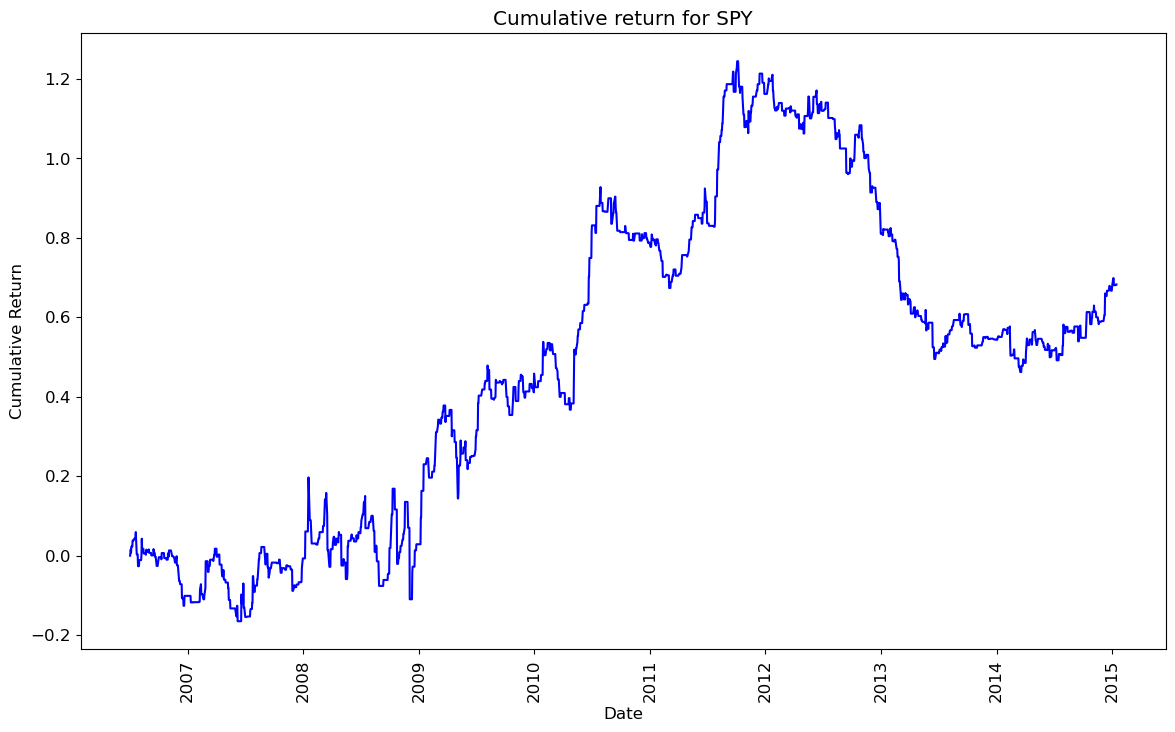

In [38]:
plt.figure(figsize = (14,8) )
plt.plot(df1.index, df.daily_ret.cumsum(), color = 'b')
plt.title(f'Cumulative return for {ticker}')
plt.xlabel('Date')
plt.xticks(rotation = 'vertical')
plt.ylabel('Cumulative Return')

In [39]:
df1.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,k2_true,k2_pnl,k0_k2,k0_k1_k2,tc,net_pnl,eod_equity,daily_ret,half_kelly,pnl_cumsum
2015-01-02,172.87,173.29,171.03,172.08,121465900.0,0.0,0.0,0.0,1.064384,0.456991,...,True,235.96,235.96,235.96,2.082,233.878,15187.248,0.015640,4.00,5187.248
2015-01-05,171.02,171.19,168.66,168.97,169632600.0,0.0,0.0,0.0,1.379956,1.198690,...,True,244.12,244.12,244.12,2.154,241.966,15429.214,0.015932,4.00,5429.214
2015-01-06,169.28,169.81,166.57,167.38,209151400.0,0.0,0.0,0.0,1.600898,1.122401,...,True,195.64,195.64,0.00,1.752,0.000,15429.214,0.000000,3.17,5429.214
2015-01-07,168.72,169.81,168.26,169.46,125346700.0,0.0,0.0,0.0,0.272641,-0.438596,...,False,-269.36,-269.36,-269.36,2.184,-271.544,15157.670,-0.017599,4.00,5157.670
2015-01-08,170.89,172.69,170.87,172.47,147217800.0,0.0,0.0,0.0,0.011703,-0.924571,...,False,-554.58,-554.58,0.00,2.106,0.000,15157.670,0.000000,4.00,5157.670
2015-01-09,172.89,172.90,170.47,171.09,158567300.0,0.0,0.0,0.0,1.399734,1.041124,...,True,240.72,240.72,0.00,2.124,0.000,15157.670,0.000000,4.00,5157.670
2015-01-12,171.22,171.38,169.14,169.75,144396100.0,0.0,0.0,0.0,1.214811,0.858545,...,True,143.48,143.48,0.00,1.266,0.000,15157.670,0.000000,2.37,5157.670
2015-01-13,170.98,172.12,167.95,169.27,214553300.0,0.0,0.0,0.0,1.772137,1.000117,...,True,27.20,27.20,27.20,0.240,26.960,15184.630,0.001779,0.45,5184.630
2015-01-14,167.23,168.45,166.33,168.25,192991100.0,0.0,0.0,0.0,0.538181,-0.609938,...,True,81.18,81.18,0.00,0.738,0.000,15184.630,0.000000,1.37,5184.630
2015-01-15,168.89,169.21,166.59,166.71,176613900.0,0.0,0.0,0.0,1.361833,1.290781,...,True,193.63,193.63,0.00,1.734,0.000,15184.630,0.000000,3.18,5184.630
